# Image Segmentation with PyTorch

In [ ]:
# install libraries/packages/modules

!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 33.40 MiB/s, done.
Resolving deltas: 100% (3/3), done.


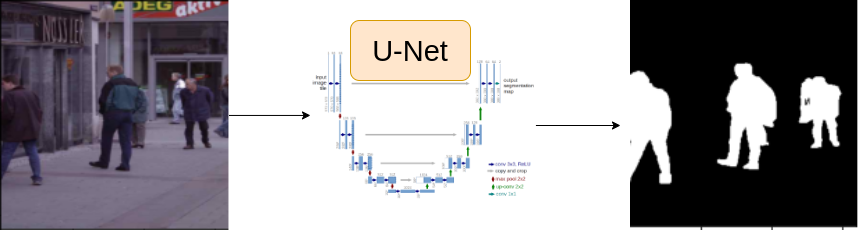

# Import Packages

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Configurations

In [ ]:
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'

device = 'cuda'
epochs = 25
lr = 0.003
img_size = 320
batch_size = 16

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [ ]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[8]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


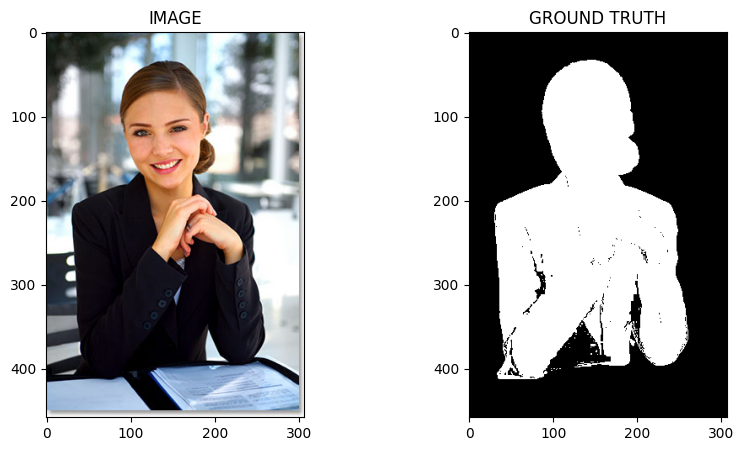

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Define Augmentations

In [ ]:
print(train_df.iloc[0])

masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 6, dtype: object


In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
      A.Resize(img_size, img_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
      ])

valid_augs = A.Compose([
      A.Resize(img_size, img_size)
      ])


# Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img_path = row.images
    mask_path = row.masks

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h,w)
    if image.shape != mask.shape:
      mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    mask = np.expand_dims(mask, axis=-1)


    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c) -> (c,h,w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, train_augs)
validset = SegmentationDataset(valid_df, valid_augs)

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


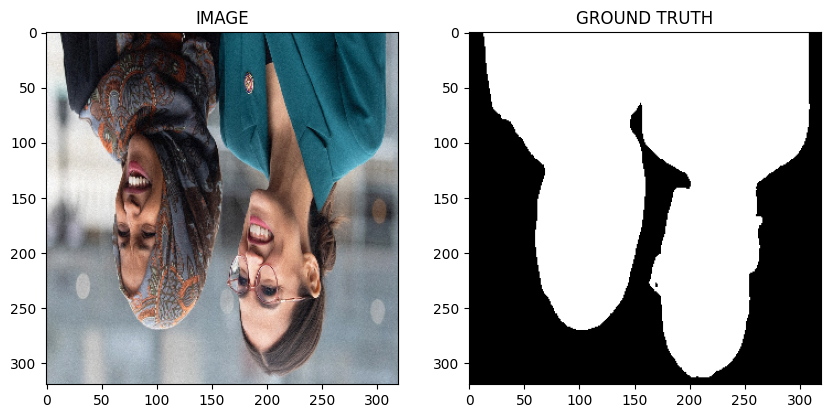

In [ ]:
idx = 200
image, mask = trainset[idx]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')


In [ ]:
trainset.df

,masks,images
6,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
209,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
223,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
261,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
73,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
...,...,...
188,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
71,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
106,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
270,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


# Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

print(f"Total number of batchces in trainloader : {len(trainloader)}")
print(f"Total number of batchces in validloader : {len(validloader)}")

Total number of batchces in trainloader : 15
Total number of batchces in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Create Segmentation Model

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks=None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(device)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 154MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
best_valid_loss = np.inf

for i in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Saved Model')
    best_valid_loss = valid_loss


  print(f'Epoch : {i+1} Train Loss : {train_loss} valid_loss : {valid_loss}')

 93%|█████████▎| 14/15 [00:09<00:00,  2.34it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


Saved Model
Epoch : 1 Train Loss : 0.7860018809636434 valid_loss : 1.1704930365085602


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Saved Model
Epoch : 2 Train Loss : 0.40396216909090676 valid_loss : 0.5152771770954132


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Saved Model
Epoch : 3 Train Loss : 0.3564592937628428 valid_loss : 0.35738571733236313


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Epoch : 4 Train Loss : 0.2567621181408564 valid_loss : 0.44442271441221237


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Saved Model
Epoch : 5 Train Loss : 0.26134813328584033 valid_loss : 0.2772107869386673


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Epoch : 6 Train Loss : 0.22109989325205484 valid_loss : 0.27849046140909195


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Saved Model
Epoch : 7 Train Loss : 0.21777885456879933 valid_loss : 0.2593526728451252


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Saved Model
Epoch : 8 Train Loss : 0.2022118290265401 valid_loss : 0.2336469478905201


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


Epoch : 9 Train Loss : 0.187936927874883 valid_loss : 0.24735495075583458


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Saved Model
Epoch : 10 Train Loss : 0.16450287451346715 valid_loss : 0.18937071412801743


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Epoch : 11 Train Loss : 0.17720851103464763 valid_loss : 0.313797052949667


100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


Epoch : 12 Train Loss : 0.25259057283401487 valid_loss : 0.22497809305787086


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Epoch : 13 Train Loss : 0.1874099979797999 valid_loss : 0.22865686938166618


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch : 14 Train Loss : 0.19657136698563893 valid_loss : 0.22243981063365936


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


Epoch : 15 Train Loss : 0.1327744871377945 valid_loss : 0.2674749232828617


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


Epoch : 16 Train Loss : 0.14556377579768498 valid_loss : 0.2340875044465065


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Saved Model
Epoch : 17 Train Loss : 0.12038464893897374 valid_loss : 0.17232226580381393


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Epoch : 18 Train Loss : 0.11618494639794032 valid_loss : 0.21980518102645874


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Epoch : 19 Train Loss : 0.09582980424165725 valid_loss : 0.20633461698889732


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Epoch : 20 Train Loss : 0.12437201887369156 valid_loss : 0.17481259256601334


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Epoch : 21 Train Loss : 0.11733789692322413 valid_loss : 0.20028532296419144


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch : 22 Train Loss : 0.11976933379968008 valid_loss : 0.2047787718474865


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch : 23 Train Loss : 0.12121413399775822 valid_loss : 0.23058426193892956


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Epoch : 24 Train Loss : 0.1299592822790146 valid_loss : 0.3399025574326515


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

Epoch : 25 Train Loss : 0.12920050869385402 valid_loss : 0.18126153014600277


# Inference

In [ ]:
idx = 15

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(device).unsqueeze(0)) # (c,h,w) -> (1,c,h,w)

pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5) * 1.0

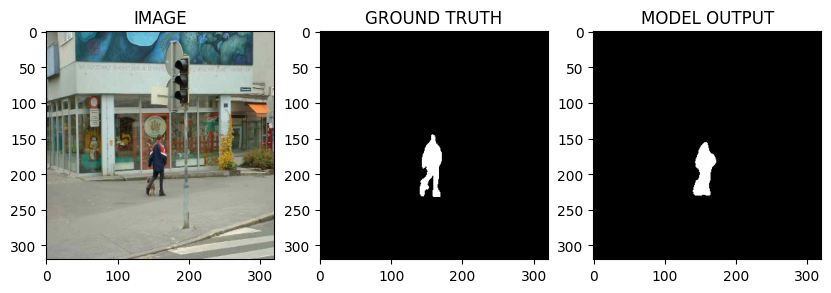

In [ ]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

ax3.set_title('MODEL OUTPUT')
ax3.imshow(pred_mask.detach().cpu().squeeze(0).permute(1,2,0).squeeze(),cmap = 'gray')